In [1]:
# Project Description
# We have a portfolio with 2 asset classes (US Total Equity, US Large Cap Value) 
# and we’d like to know the benefit of Tax-Loss Harvesting (TLH) in the portfolio with a simplified setup. 
# See the description of Tax Loss Harvesting here and here.
# The portfolio allocation is 80% US Total Equity, 20% US Large Cap Value and 
# the below is the primary/secondary ticker information for the asset classes.
# US Total Equity: VTI as a primary ticker, SCHB as a secondary ticker
# US Large Cap Value: VTV as a primary ticker, SCHV as a secondary ticker
# Through a backtest, analyze the benefit of TLH in the portfolio for the following scenario:
# Invest $50K at the beginning of the investment period and and additional $10K at the 
# end of each year for the first 5 years

# Data
# Price data from 2010 through 2022
# All prices have been adjusted for splits, dividends, and other corporate actions.

# Steps for backtesting
# (1) We begin with a small Exploratory Data Analysis (EDA) to analyze the data
# (2) We construct the portfolio without TLH
# (3) We check for historical TLH opportunities
# (4) Compare the final values of the portfolios with and without TLH treatment 


In [2]:
#First we will run a simple EDA to understand the data 

#EDA
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the data
data = pd.read_excel('price data from 2010 - 2022.xlsx', index_col='Date', parse_dates=True)

# Check Data
print(data.head())
print(data.describe())

# Check for missing data 
print(data.isnull().sum()) #No missing data found

                VTI     SCHB      VTV     SCHV
Date                                          
2010-01-04  44.8593  10.5497  34.5132  17.9468
2010-01-05  45.0315  10.5852  34.6270  18.0218
2010-01-06  45.0941  10.5930  34.7407  18.0779
2010-01-07  45.2820  10.6300  34.9326  18.1761
2010-01-08  45.4307  10.6600  34.9682  18.1621
               VTI         SCHB          VTV         SCHV
count  3272.000000  3272.000000  3272.000000  3272.000000
mean    112.237452    26.331015    78.212303    39.676473
std      53.066389    12.411876    31.806214    15.078944
min      41.125000     9.678200    31.773700    16.691200
25%      67.220875    15.795575    50.640875    27.060050
50%      95.885950    22.525950    71.300000    37.051450
75%     140.818050    32.986675    98.095400    49.404900
max     238.120200    55.758400   146.836200    71.997700
VTI     0
SCHB    0
VTV     0
SCHV    0
dtype: int64


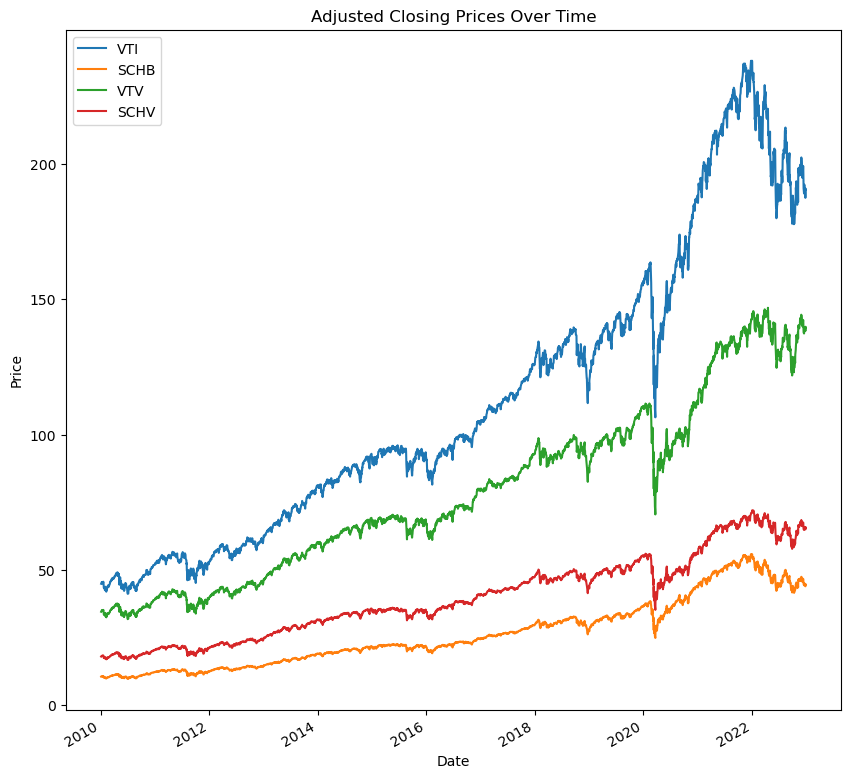

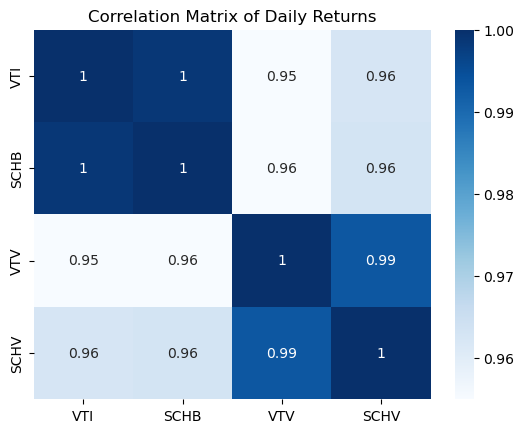

In [4]:
# Plot price trends
data.plot(figsize=(10, 10))
plt.title('Adjusted Closing Prices Over Time')
plt.ylabel('Price')
plt.show()

# Correlation matrix
returns = data.pct_change().dropna()
corr_matrix = returns.corr()
sns.heatmap(corr_matrix, annot=True, cmap='Blues')
plt.title('Correlation Matrix of Daily Returns')
plt.show()

# Observations: Daily returns are highly correlated with one another i.e. have a high level of co-movement 
# and are likely influenced by similar risk factors. This makes sense in the capacity that, if I have to sell 
# a security at a loss, then I want to buy a similar security and not hold any cash in the portfolio. 

In [5]:
# So now we begin to construct the portfolio given the initial investment and annual contributions
# We are given additional information about the allocation percentages in the portfolios (80-20) with primary
# vs secondary tickers

# Lets build the class and function structure prior to initializing this with actual numerical values.

class NoTLHPortfolio:
    
    def __init__(self, data, initial_contribution, annual_contribution,
                 date_start, date_end, primary_tickers, secondary_tickers, target_allocation,
                 long_term_capital_gains_tax):
        
        self.data = data
        self.initial_contribution = initial_contribution
        self.annual_contribution = annual_contribution
        self.date_start = date_start
        self.date_end = date_end
        self.primary_tickers = primary_tickers
        self.secondary_tickers = secondary_tickers
        self.target_alloc = target_allocation

        # Added the tax rate provided in the prompt for calculating total portfolio value

        #self.ordinary_income_tax = ordinary_income_tax #Unused for non TLH portfolio
        
        self.long_term_capital_gains_tax = long_term_capital_gains_tax

        # We need a holder for the portfolio value that can be accessed by all the functions in this class

        self.portfolio_val = []
        
        # Since the output required needs daily records
        
        self.daily_log = []


        # Call functions

        self.initial_shares = self.initialize_shares()
    
    
    ########################################################################
    
    def initialize_shares(self):
        
        # This function calculaates shares purchased based on the initial contribution and target allocation
        # prior to annual contributions
        
        initial_shares = {}
        
        
        for asset_class, t in self.primary_tickers.items():
            
            allocation = self.target_alloc.get(asset_class,0)
            
            price_primary_securities = self.data[t].iloc[0]
            price_secondary_securities = self.data[self.secondary_tickers[asset_class]].iloc[0]
            
            initial_shares[asset_class] = {
                
                'primary': (self.initial_contribution * allocation * 0.8) / price_primary_securities,
                'secondary': (self.initial_contribution * allocation * 0.2) / price_secondary_securities
                
            }
                        
        # where t is tickers

        return initial_shares

    def add_annual_contributions(self, date):
        
        # The idea here is that every year, for 5 years, we ad 10k to our portfolio and allocate it, 
        # in accordance with the original allocation
        
        for asset_class, t in self.primary_tickers.items():
            allocation = self.target_alloc[asset_class]
            yearly_contrib = (self.annual_contribution * allocation)/self.data[t].iloc[0]
            price_primary_securities = self.data[t].iloc[0]
            price_secondary_securities = self.data[self.secondary_tickers[asset_class]].iloc[0]
            
            # Calculate additional shares purchased with the additional allocation
            
            added_shares_p = (yearly_contrib * 0.8)/price_primary_securities
            added_shares_s = (yearly_contrib * 0.2)/price_secondary_securities
            
            # update portfolio
            
            self.initial_shares[asset_class]['primary'] += added_shares_p
            self.initial_shares[asset_class]['secondary'] += added_shares_s

        
    # Now lets calculate the value of our portfolio WITHOUT TLH considerations
    # Simple calculations of shares*closingprice at every date in the dataset
    # append to that earlier empty list
    
    def calculate_portfolio_value(self, date):
        
        initial_val = 0
        
        daily_log = {'Date': date}
        
        for asset_class, t in self.primary_tickers.items():
            price_primary_securities = self.data[t].loc[date]
            price_secondary_securities = self.data[self.secondary_tickers[asset_class]].loc[date]
            
            amount_of_primary = self.initial_shares[asset_class]['primary']
            amount_of_secondary = self.initial_shares[asset_class]['secondary']
            
            primary_value = price_primary_securities * amount_of_primary
            secondary_value = price_secondary_securities * amount_of_secondary
            
            # Final portfolio value
            
            initial_val += primary_value+secondary_value
            
            # Needed for output -- daily trade log
            
            daily_log[t] = amount_of_primary
            daily_log[self.secondary_tickers[asset_class]] =secondary_value
        
        self.portfolio_val.append((date,initial_val))
        
        return initial_val
    
        
    # In the assumptions there is a mention of ordinary tax and a long term capital gains tax
    
    def tax(self):
        
        # holding the portfolio for our 5 year period would make it succeptible to 
        # long-term capital gains tax only 
        # but any trade for a security held less than a year is consider short term gains or ordinary 
        
        # From Assumption 7: "On the last day of the investment period, the portfolio is fully liquidated, 
        # and all taxes are paid, with no annual tax payments."

        
        initial_val = self.initial_contribution
        total_contributions = initial_val + self.annual_contribution*5 #for 5 years of investment
        final_val = self.portfolio_val[-1][1]
        
        final_profit = final_val - total_contributions
        
        tax = max(0, final_profit) * self.long_term_capital_gains_tax

        #tax = final_profit*self.long_term_capital_gains_tax
        
        return final_profit, tax
        
    
    def backtest(self):
        
        #Date range needed for backtest -- prompt identifies this as 2013 to 2022
        
        for date in self.data.loc[self.date_start:self.date_end].index:
            
            if date.month == 1 and date.day == 2:
                self.add_annual_contributions(date)
            
            self.calculate_portfolio_value(date)
        
        final_profit, tax = self.tax()
        net_val = self.portfolio_val[-1][1] - tax
        
        print(f"total gain: ${final_profit:,.2f}")
        
        print(f"Tax Due: ${tax:,.2f}")

        print(f"Final Portfolio Value After Tax: ${net_val:,.2f}")
    


# Instantiate this class 
              
# Since there are just a few securities in the portfolio, we can pass them through as a dict

primary_tickers = {'US Total Equity': 'VTI', 'US Large Cap Value': 'VTV'}
secondary_tickers = {'US Total Equity': 'SCHB', 'US Large Cap Value': 'SCHV'}
target_allocation = {'US Total Equity': 0.80, 'US Large Cap Value': 0.20}
              
initial_contribution = 50000
annual_contribution = 10000
date_start = '2013-01-01'
date_end = '2022-12-31'

portfolio = NoTLHPortfolio(data, initial_contribution,annual_contribution, date_start, 
                                  date_end, primary_tickers, secondary_tickers, target_allocation,long_term_capital_gains_tax=0.15)

#Run backtest 
portfolio.backtest()
              
# total gain: $115,255.91
# Tax Due: $17,288.39
# Final Portfolio Value After Tax: $197,967.52

# Comments: Using a 12% annual growth as a sanity check
# so if I take a 50,000 investment, I can model this as 50k*(1+0.12)^9 = about 138k + the 5 other contribs i.e. J
# it would be like J = 10k + (1+0.12)^x where x is X in the set {8,7,6,5,4} 
# Doing this calculation quickly in excel says my total should be around 50k*(1+0.12)^9 + sigma(J) = 238,617.22
# My projected gain is $115,225.91 i.e. off by around 5-6k as I'm at 232,544.30
# There seems to be some discrepency perhaps due to the growth rate not being 12% for the portfolio

total gain: $115,255.91
Tax Due: $17,288.39
Final Portfolio Value After Tax: $197,967.52


In [10]:
# TLH portfolio
# The TLH algorithm from the prompt is the following:
# The tax-loss harvesting (TLH) threshold is set at 2%, meaning if possible,
# given the wash sale constraint, a loss on a tax lot is harvested if its price has dropped more than 2% 
# from the acquired price by selling the lot in question and using the proceeds to buy an alternate ticker.

# Things I consider:
# (1) TLH scanning occurs daily using the provided closing prices.
# (2) The tax savings from TLH are added to the portfolio at the end of each year.
# (3) The ordinary income tax rate is 30%, and the long-term capital gain tax rate is 15%.
# (4) Wash sales must be avoided. A simplified wash sale rule is used: if a security is bought within 30 days after the same ticker has been sold at a loss, it is considered a wash sale.


class TLHPortfolio:
    def __init__(self, tickers, data, start_date, end_date, initial_investment, annual_contribution, 
                 allocation, primary_tickers, secondary_tickers, tax_loss_threshold, 
                 ordinary_income_tax_rate, long_term_capital_gain_tax_rate, contribution_years=5):
        
        self.tickers = tickers
        self.data = data
        self.start_date = start_date
        self.end_date = end_date
        
        self.initial_investment = initial_investment
        self.annual_contribution = annual_contribution
        self.allocation = allocation
        
        self.primary_tickers = primary_tickers
        self.secondary_tickers = secondary_tickers
        
        self.tax_loss_threshold = tax_loss_threshold
        
        self.ordinary_income_tax_rate = ordinary_income_tax_rate
        self.long_term_capital_gain_tax_rate = long_term_capital_gain_tax_rate
        self.contribution_years = contribution_years
        
        # Needed this field to initialize the calculations
        self.initial_shares = self.calculate_initial_shares()
        
        # calculate and really store contributions
        self.contributions = self.calculate_contributions()
        
        self.purchase_prices = {ticker: self.data[ticker].iloc[0] for ticker in primary_tickers.values()}
        self.total_shares = self.initial_shares.copy()
        
        self.tax_savings = 0
        
        # Empty lists to fill
        self.tlh_transactions = []
        self.daily_portfolio_records = []
        self.portfolio_value_with_tlh = []
        self.investment_year = 0
        
        self.last_sale_date = {}

    # Have to do this by shares we have initially and then how much more gets added on
    
    def calculate_initial_shares(self):
        return {
            asset_class: (self.initial_investment * self.allocation[asset_class]) / self.data[ticker].iloc[0]
            for asset_class, ticker in self.primary_tickers.items()
        }
    
    # calculates annual contributions
    def calculate_contributions(self):
        return {
            asset_class: self.annual_contribution * self.allocation[asset_class]
            for asset_class in self.primary_tickers
        }

    # for the 5 annual contributions, we add them to the initial principal
    def apply_annual_contributions(self, date):
        for asset_class, t in self.primary_tickers.items():
            additional_shares = self.contributions[asset_class] / self.data[t].loc[date]
            self.total_shares[asset_class] += additional_shares
            self.purchase_prices[t] = self.data[t].loc[date]
    
    # scan for tlh opportunities on each date and then store that in tax_lots
    # logic: scan primary price, if (1 + threshold) * purchase_price > current_primary_price, sell
    # find secondary_ticker[asset_class] and its current price, buy
        
    def tlh_opportunities(self, date):
        closing_prices = self.data.loc[date]
        
        for asset_class, primary_ticker in self.primary_tickers.items():
            secondary_ticker = self.secondary_tickers[asset_class]
            
            # logic
            if closing_prices[primary_ticker] < self.purchase_prices[primary_ticker] * (1 + self.tax_loss_threshold):
                self.execute_tlh_trade(date, asset_class, primary_ticker, secondary_ticker)
            #else:
                #print("Threshold Val is not violated. No trade needed. Hold position.")
                
    def execute_tlh_trade(self, date, asset_class, primary_ticker, secondary_ticker):
        primary_price = self.data[primary_ticker].loc[date]
        secondary_price = self.data[secondary_ticker].loc[date]
        
        primary_shares_held = self.total_shares[asset_class]
        revenue_from_sale = primary_shares_held * primary_price
        shares_bought_as_replacement = revenue_from_sale / secondary_price
        
        # Wash rule
        if primary_ticker in self.last_sale_date:
            check = (date - self.last_sale_date[primary_ticker]).days
            if check < 30:
                print("Wash rule violated; do not trade")
                return
            
        # Update current shares values
        self.total_shares[asset_class] = shares_bought_as_replacement
        self.purchase_prices[secondary_ticker] = secondary_price  
                                                       
    
        # Prompt asks for a reason for the trade i.e. the tax related event
        loss = ((self.purchase_prices[primary_ticker] - primary_price) /
                self.purchase_prices[primary_ticker]) * 100
        
        if (date - pd.Timestamp(self.purchase_prices[primary_ticker])).days < 365:
            self.tax_savings += loss * self.ordinary_income_tax_rate
            tax_event = "Short term capital loss"
        else:
            self.tax_savings += loss * self.long_term_capital_gain_tax_rate
            tax_event = "Long term capital loss"
        
        print(f"Executed TLH transaction on: {date}")
        print(f"Sold {primary_shares_held} of {primary_ticker}")
        print(f"Bought {shares_bought_as_replacement} of {secondary_ticker}")
        
        self.tlh_transactions.append({
            'Date': date,
            'Primary Ticker': primary_ticker,
            'Secondary Ticker': secondary_ticker,
            'Shares Sold': primary_shares_held,
            'Sell Price': primary_price,
            'Buy Price': secondary_price,
            'Shares Bought': shares_bought_as_replacement,
            'Trade Reason': f'TLH Sale:{tax_event} LOSS: {loss:.2f}%'
        })
        
        # Log date for Wash rule
        self.last_sale_date[primary_ticker] = date
        
        # We need to switch what is primary and what is secondary as the whole amount moves per trade
        self.primary_tickers[asset_class], self.secondary_tickers[asset_class] = secondary_ticker, primary_ticker      

    # Need a way to update the portfolio values after trades
    def update_port(self, date):
        prices = self.data.loc[date]
        port_value = sum(self.total_shares[asset_class] * prices[ticker] 
                         for asset_class, ticker in self.primary_tickers.items())

        # Record the portfolio value and shares held
        record = {'Date': date, 'Portfolio Value': port_value}
        for asset_class, shares in self.total_shares.items():
            record[self.primary_tickers[asset_class]] = shares
        
        self.daily_portfolio_records.append(record)
        # Used for display ... from earlier version                                                
        self.portfolio_value_with_tlh.append((date, port_value))

    def backtest(self):
        for date in self.data.loc[self.start_date:self.end_date].index:
            if self.investment_year < self.contribution_years and date.month == 1 and date.day == 2:
                self.apply_annual_contributions(date)
                self.investment_year += 1

            self.tlh_opportunities(date)
            self.update_port(date)

        # Reinvest tax savings at the end of the year from assumption 5 (from prompt)
        if self.tax_savings > 0:
            for asset_class, ticker in self.primary_tickers.items():
                additional_shares = (self.tax_savings * self.allocation[asset_class]) / self.data[ticker].iloc[-1]
                self.total_shares[asset_class] += additional_shares
            self.tax_savings = 0

    def display_results(self):
        if self.portfolio_value_with_tlh:
            print(f"Final Portfolio Value With TLH: ${self.portfolio_value_with_tlh[-1][1]:,.2f}")
        else:
            print("No data for Portfolio Value With TLH.")
        
        tlh_transactions_df = pd.DataFrame(self.tlh_transactions)
        print("\nTLH Transactions:")
        print(tlh_transactions_df)

        daily_portfolio_records_df = pd.DataFrame(self.daily_portfolio_records)
        print("\nDaily Portfolio Records:")
        print(daily_portfolio_records_df)

# Define the parameters
data = pd.read_excel('price data from 2010 - 2022.xlsx', index_col='Date', parse_dates=True)
primary_tickers = {'US Total Equity': 'VTI', 'US Large Cap Value': 'VTV'}
secondary_tickers = {'US Total Equity': 'SCHB', 'US Large Cap Value': 'SCHV'}
initial_investment = 50000
annual_contribution = 10000
date_start = '2013-01-01'
date_end = '2022-12-31'
allocation = {'US Total Equity': 0.80, 'US Large Cap Value': 0.20}
tax_loss_threshold = -0.02
ordinary_income_tax_rate = 0.30
long_term_capital_gain_tax_rate = 0.15

# Instantiate and run the portfolio manager
TLHPortfolio_instantiate = TLHPortfolio(
    tickers=['VTI', 'VTV', 'SCHB', 'SCHV'],
    data=data,
    start_date=date_start,
    end_date=date_end,
    initial_investment=initial_investment,
    annual_contribution=annual_contribution,
    allocation=allocation,
    primary_tickers=primary_tickers,
    secondary_tickers=secondary_tickers,
    tax_loss_threshold=tax_loss_threshold,
    ordinary_income_tax_rate=ordinary_income_tax_rate,
    long_term_capital_gain_tax_rate=long_term_capital_gain_tax_rate
)

TLHPortfolio_instantiate.backtest()
TLHPortfolio_instantiate.display_results()


Executed TLH transaction on: 2014-01-24 00:00:00
Sold 366.33876522473713 of VTV
Bought 699.1706945160969 of SCHV
Executed TLH transaction on: 2014-01-27 00:00:00
Sold 1119.0122644247606 of VTI
Bought 4771.943329380813 of SCHB
Executed TLH transaction on: 2014-02-03 00:00:00
Sold 4771.943329380813 of SCHB
Bought 1119.9548144084595 of VTI
Executed TLH transaction on: 2014-02-03 00:00:00
Sold 699.1706945160969 of SCHV
Bought 365.7485767933561 of VTV
Executed TLH transaction on: 2015-01-06 00:00:00
Sold 1207.4500021731324 of VTI
Bought 5139.164889142554 of SCHB
Executed TLH transaction on: 2015-01-06 00:00:00
Sold 395.0671257597307 of VTV
Bought 764.5586090320459 of SCHV
Executed TLH transaction on: 2015-08-21 00:00:00
Sold 764.5586090320459 of SCHV
Bought 391.1054840526021 of VTV
Executed TLH transaction on: 2015-08-24 00:00:00
Sold 5139.164889142554 of SCHB
Bought 1209.8314623852305 of VTI
Executed TLH transaction on: 2015-08-24 00:00:00
Sold 391.1054840526021 of VTV
Bought 762.543740672